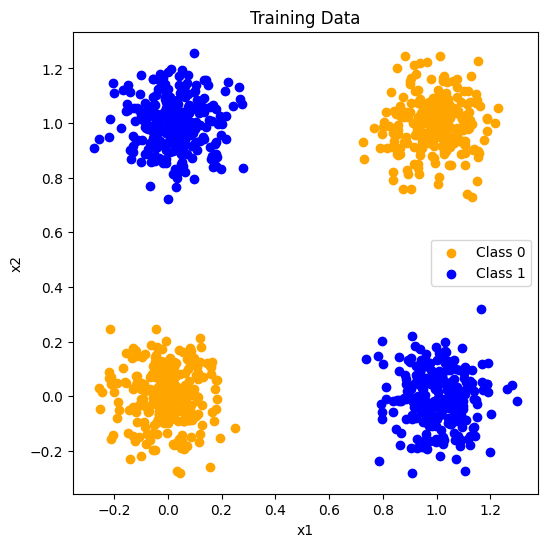

Epoch 1/20, Validation Loss: 0.6844
Epoch 2/20, Validation Loss: 0.6649
Epoch 3/20, Validation Loss: 0.6242
Epoch 4/20, Validation Loss: 0.5339
Epoch 5/20, Validation Loss: 0.3916
Epoch 6/20, Validation Loss: 0.2740
Epoch 7/20, Validation Loss: 0.1985
Epoch 8/20, Validation Loss: 0.1506
Epoch 9/20, Validation Loss: 0.1193
Epoch 10/20, Validation Loss: 0.0974
Epoch 11/20, Validation Loss: 0.0817
Epoch 12/20, Validation Loss: 0.0697
Epoch 13/20, Validation Loss: 0.0606
Epoch 14/20, Validation Loss: 0.0530
Epoch 15/20, Validation Loss: 0.0471
Epoch 16/20, Validation Loss: 0.0421
Epoch 17/20, Validation Loss: 0.0380
Epoch 18/20, Validation Loss: 0.0346
Epoch 19/20, Validation Loss: 0.0315
Epoch 20/20, Validation Loss: 0.0289


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
val_loss,██▇▆▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁
epoch,20
val_loss,0.02886


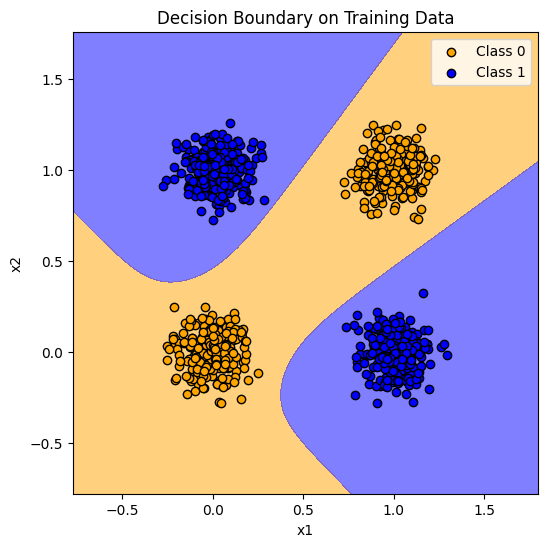

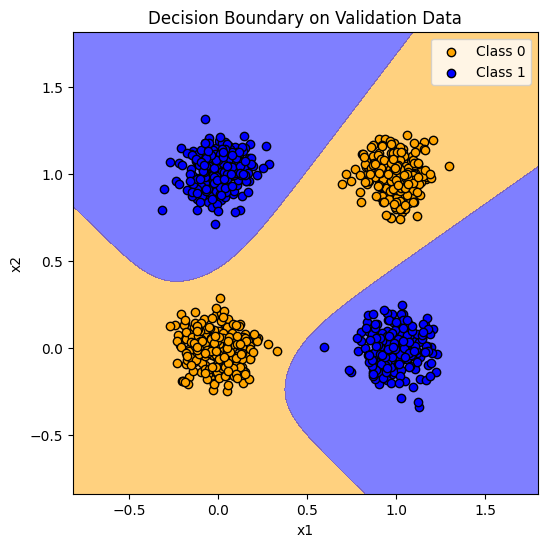


Testing model with depth 0 and width 1
Repeat 1/5, Test Loss: 0.6967
Repeat 2/5, Test Loss: 0.6951
Repeat 3/5, Test Loss: 0.6940
Repeat 4/5, Test Loss: 0.6991
Repeat 5/5, Test Loss: 0.6983

Testing model with depth 0 and width 2
Repeat 1/5, Test Loss: 0.6934
Repeat 2/5, Test Loss: 0.6935
Repeat 3/5, Test Loss: 0.6938
Repeat 4/5, Test Loss: 0.6945
Repeat 5/5, Test Loss: 0.6939

Testing model with depth 0 and width 3
Repeat 1/5, Test Loss: 0.7032
Repeat 2/5, Test Loss: 0.6942
Repeat 3/5, Test Loss: 0.6935
Repeat 4/5, Test Loss: 0.6994
Repeat 5/5, Test Loss: 0.6937

Testing model with depth 1 and width 1
Repeat 1/5, Test Loss: 0.6940
Repeat 2/5, Test Loss: 0.5393
Repeat 3/5, Test Loss: 0.5163
Repeat 4/5, Test Loss: 0.5089
Repeat 5/5, Test Loss: 0.5009

Testing model with depth 1 and width 2
Repeat 1/5, Test Loss: 0.3628
Repeat 2/5, Test Loss: 0.0671
Repeat 3/5, Test Loss: 0.0658
Repeat 4/5, Test Loss: 0.3753
Repeat 5/5, Test Loss: 0.0635

Testing model with depth 1 and width 3
Repeat 1/5

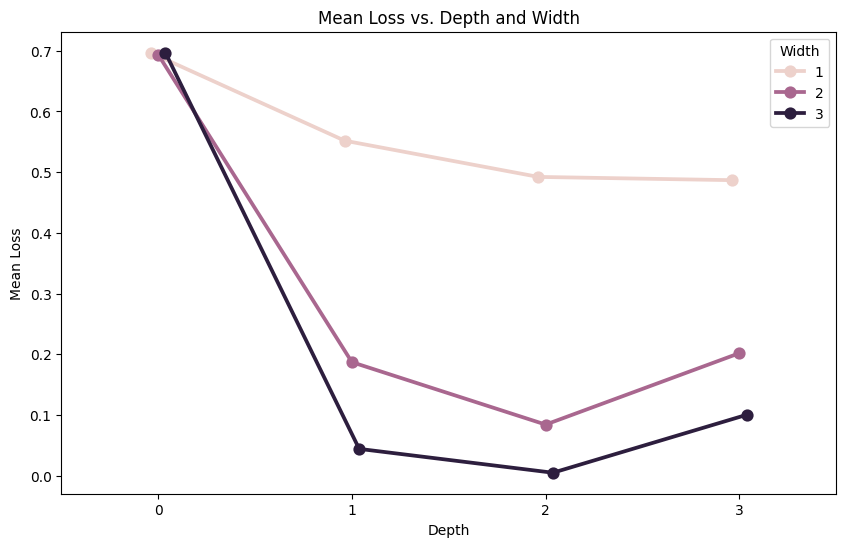

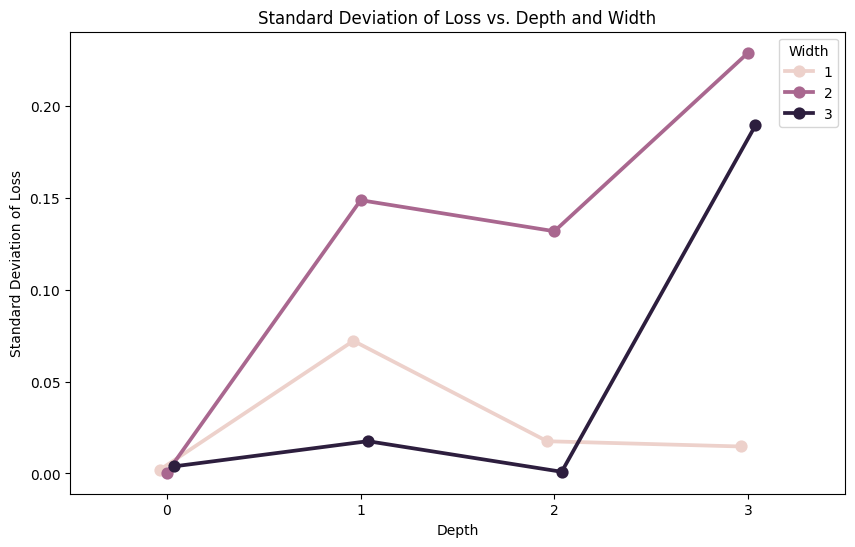

In [5]:
# feedforwardAssignment.ipynb

# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

import wandb

# Data generation class for the noisy XOR problem
class NoisyXORDataset(Dataset):
    def __init__(self, n_samples=1000, s=0.1):
        self.n_samples = n_samples
        self.s = s
        self.data = []
        self.targets = []
        self.generate_data()
        
    def generate_data(self):
        m_list = [(0, 0), (0, 1), (1, 0), (1, 1)]
        for _ in range(self.n_samples):
            m1, m2 = m_list[np.random.randint(0, 4)]
            eta1, eta2 = np.random.randn(2)
            x1 = m1 + self.s * eta1
            x2 = m2 + self.s * eta2
            y = m1 ^ m2  # XOR operation
            self.data.append([x1, x2])
            self.targets.append(y)
        self.data = np.array(self.data, dtype=np.float32)
        self.targets = np.array(self.targets, dtype=np.float32)
        
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]
    
# Original Model class implementing the feed-forward neural network
class FeedforwardNN(nn.Module):
    def __init__(self):
        super(FeedforwardNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 3, bias=True),
            nn.Tanh(),
            nn.Linear(3, 1, bias=True),
            nn.Identity()
        )
        
    def forward(self, x):
        return self.model(x)
    
# Visualization functions
def plot_data(dataset, title):
    data = dataset.data
    targets = dataset.targets
    plt.figure(figsize=(6,6))
    plt.scatter(data[targets==0, 0], data[targets==0, 1], color='orange', label='Class 0')
    plt.scatter(data[targets==1, 0], data[targets==1, 1], color='blue', label='Class 1')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend()
    plt.title(title)
    plt.show()
    
def plot_decision_boundary(model, dataset, title):
    x_min, x_max = dataset.data[:, 0].min() - 0.5, dataset.data[:, 0].max() + 0.5
    y_min, y_max = dataset.data[:, 1].min() - 0.5, dataset.data[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_tensor = torch.from_numpy(grid).float()
    with torch.no_grad():
        outputs = model(grid_tensor)
        probs = torch.sigmoid(outputs).numpy()
    probs = probs.reshape(xx.shape)
    
    plt.figure(figsize=(6,6))
    plt.contourf(xx, yy, probs, levels=[0, 0.5, 1], colors=['orange', 'blue'], alpha=0.5)
    plt.scatter(dataset.data[dataset.targets==0, 0], dataset.data[dataset.targets==0, 1], color='orange', edgecolor='k', label='Class 0')
    plt.scatter(dataset.data[dataset.targets==1, 0], dataset.data[dataset.targets==1, 1], color='blue', edgecolor='k', label='Class 1')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend()
    plt.title(title)
    plt.show()


num_epochs = 20
batch_size = 32


# Initialize a new wandb run & wandb config - 4.1
run = wandb.init(project='noisy-xor-classification_4')
config = wandb.config
config.learning_rate = 0.01
config.epochs = num_epochs
config.batch_size = batch_size


# Generate training and validation datasets
train_dataset = NoisyXORDataset(n_samples=1000, s=0.1)
val_dataset = NoisyXORDataset(n_samples=1000, s=0.1)

# Plot training data
plot_data(train_dataset, 'Training Data')

# Original model training (for the first two tasks)
# Create DataLoaders for mini-batch learning
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model, loss function, and optimizer
model = FeedforwardNN()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop with mini-batch learning
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (data, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(data)
        targets = targets.unsqueeze(1)  # Reshape targets to [batch_size, 1]
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    
    # Evaluate on validation set
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for data, targets in val_loader:
            outputs = model(data)
            targets = targets.unsqueeze(1)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
        val_loss /= len(val_loader)

    # Log metrics to W&B
    wandb.log({
        'epoch': epoch + 1,
        'val_loss': val_loss
    })

    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}')

# stop the wandb, since we aren't logging more information
wandb.finish()

# Plot decision boundary on training data
plot_decision_boundary(model, train_dataset, 'Decision Boundary on Training Data')

# Plot decision boundary on validation data
plot_decision_boundary(model, val_dataset, 'Decision Boundary on Validation Data')

# ---------------------------------------------------------------------------
# Update: Testing a Range of Networks with Different Depths and Widths
# ---------------------------------------------------------------------------

import itertools
import pandas as pd

# Define the range of depths and widths
depths = [0, 1, 2, 3]  # Number of hidden layers
widths = [1, 2, 3]     # Units per hidden layer

# Function to create a model with given depth and width
def create_model(input_size, output_size, hidden_layers, hidden_units):
    layers = []
    in_features = input_size
    for _ in range(hidden_layers):
        layers.append(nn.Linear(in_features, hidden_units))
        layers.append(nn.Tanh())
        in_features = hidden_units
    layers.append(nn.Linear(in_features, output_size))
    layers.append(nn.Identity())
    return nn.Sequential(*layers)

# Initialize a DataFrame to store results
results = []

# Number of times to repeat training for each configuration
repeats = 5

# Loop over all combinations of depths and widths
for depth, width in itertools.product(depths, widths):
    print(f'\nTesting model with depth {depth} and width {width}')
    losses = []
    for repeat in range(repeats):
        # Create new datasets for each repeat
        train_dataset = NoisyXORDataset(n_samples=1000, s=0.1)
        val_dataset = NoisyXORDataset(n_samples=1000, s=0.1)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
        # Create the model
        model = create_model(input_size=2, output_size=1, hidden_layers=depth, hidden_units=width)
        
        # Define loss function and optimizer
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.01)
        
        # Training loop
        num_epochs = 20
        for epoch in range(num_epochs):
            model.train()
            for data, targets in train_loader:
                optimizer.zero_grad()
                outputs = model(data)
                targets = targets.unsqueeze(1)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
        
        # Evaluate on a new dataset
        test_dataset = NoisyXORDataset(n_samples=1000, s=0.1)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        model.eval()
        with torch.no_grad():
            test_loss = 0
            for data, targets in test_loader:
                outputs = model(data)
                targets = targets.unsqueeze(1)
                loss = criterion(outputs, targets)
                test_loss += loss.item()
            test_loss /= len(test_loader)
        losses.append(test_loss)
        print(f'Repeat {repeat+1}/{repeats}, Test Loss: {test_loss:.4f}')
    
    mean_loss = np.mean(losses)
    std_loss = np.std(losses)
    results.append({'Depth': depth, 'Width': width, 'Mean Loss': mean_loss, 'Std Loss': std_loss})

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display the results
print('\nResults:')
print(results_df)

# Visualize the results
import seaborn as sns

# Plot Mean Loss vs. Depth and Width
plt.figure(figsize=(10,6))
sns.pointplot(data=results_df, x='Depth', y='Mean Loss', hue='Width', dodge=True, markers='o', linestyles='-')
plt.title('Mean Loss vs. Depth and Width')
plt.ylabel('Mean Loss')
plt.show()

# Plot Std Loss vs. Depth and Width
plt.figure(figsize=(10,6))
sns.pointplot(data=results_df, x='Depth', y='Std Loss', hue='Width', dodge=True, markers='o', linestyles='-')
plt.title('Standard Deviation of Loss vs. Depth and Width')
plt.ylabel('Standard Deviation of Loss')
plt.show()


In [14]:
# Assignment 4.2
def train():
    # Initialize a new W&B run
    run = wandb.init(project='noisy-xor-sweep')

    config = wandb.config

    # Generate training and validation datasets
    train_dataset = NoisyXORDataset(n_samples=1000, s=0.1)
    val_dataset = NoisyXORDataset(n_samples=1000, s=0.1)

    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)

    # Create the model
    model = create_model(input_size=2, output_size=1, hidden_layers=config.depth, hidden_units=config.width)

    # Define loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

    # Training loop
    for epoch in range(config.epochs):
        model.train()
        running_loss = 0.0
        for data, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(data)
            targets = targets.unsqueeze(1)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * data.size(0)
        avg_train_loss = running_loss / len(train_loader.dataset)

        # Evaluate on validation set
        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for data, targets in val_loader:
                outputs = model(data)
                targets = targets.unsqueeze(1)
                loss = criterion(outputs, targets)
                val_running_loss += loss.item() * data.size(0)
        avg_val_loss = val_running_loss / len(val_loader.dataset)

        # Log metrics to W&B
        wandb.log({
            'epoch': epoch + 1,
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
            'width': config.width,
            'depth': config.depth,
            'learning_rate': config.learning_rate,
            'batch_size': config.batch_size,
        })

        print(f'Epoch {epoch+1}/{config.epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    # Finish the W&B run
    wandb.finish()

# Define the sweep configuration
sweep_config = {
    'method': 'grid',
    'metric': {
        'name': 'val_loss',
        'goal': 'minimize'   
    },
    'parameters': {
        'depth': {
            'values': [1, 3]
        },
        'width': {
            'values': [1, 3]
        },
        'learning_rate': {
            'values': [0.001, 0.1]
        },
        'batch_size': {
            'values': [32, 64]
        },
        'epochs': {
            'value': 20
        }
    }
}

# Initialize the sweep
sweep_id = wandb.sweep(sweep_config, project='noisy-xor-sweep')
# Run the sweep 10 times, and seemingly just make a good guess of the best parameter, if it overwhelms 
wandb.agent(sweep_id, function=train, count=16)


Create sweep with ID: ywlftu7l
Sweep URL: https://wandb.ai/yolo-hb-copenhagen-university/noisy-xor-sweep/sweeps/ywlftu7l


wandb: Agent Starting Run: mf0pe1dz with config:
wandb: 	batch_size: 32
wandb: 	depth: 1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	width: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20, Train Loss: 0.7035, Val Loss: 0.7018
Epoch 2/20, Train Loss: 0.7012, Val Loss: 0.7001
Epoch 3/20, Train Loss: 0.6993, Val Loss: 0.6985
Epoch 4/20, Train Loss: 0.6978, Val Loss: 0.6972
Epoch 5/20, Train Loss: 0.6967, Val Loss: 0.6963
Epoch 6/20, Train Loss: 0.6958, Val Loss: 0.6955
Epoch 7/20, Train Loss: 0.6950, Val Loss: 0.6950
Epoch 8/20, Train Loss: 0.6944, Val Loss: 0.6943
Epoch 9/20, Train Loss: 0.6938, Val Loss: 0.6939
Epoch 10/20, Train Loss: 0.6932, Val Loss: 0.6935
Epoch 11/20, Train Loss: 0.6928, Val Loss: 0.6931
Epoch 12/20, Train Loss: 0.6924, Val Loss: 0.6928
Epoch 13/20, Train Loss: 0.6920, Val Loss: 0.6925
Epoch 14/20, Train Loss: 0.6915, Val Loss: 0.6921
Epoch 15/20, Train Loss: 0.6910, Val Loss: 0.6917
Epoch 16/20, Train Loss: 0.6906, Val Loss: 0.6913
Epoch 17/20, Train Loss: 0.6901, Val Loss: 0.6909
Epoch 18/20, Train Loss: 0.6895, Val Loss: 0.6904
Epoch 19/20, Train Loss: 0.6889, Val Loss: 0.6899
Epoch 20/20, Train Loss: 0.6883, Val Loss: 0.6893


batch_size,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
depth,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁
val_loss,█▇▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁
width,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_size,32
depth,1
epoch,20
learning_rate,0.001


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: poig1guc with config:
wandb: 	batch_size: 32
wandb: 	depth: 1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	width: 3
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20, Train Loss: 0.7733, Val Loss: 0.7856
Epoch 2/20, Train Loss: 0.7548, Val Loss: 0.7664
Epoch 3/20, Train Loss: 0.7403, Val Loss: 0.7520
Epoch 4/20, Train Loss: 0.7288, Val Loss: 0.7395
Epoch 5/20, Train Loss: 0.7201, Val Loss: 0.7303
Epoch 6/20, Train Loss: 0.7132, Val Loss: 0.7230
Epoch 7/20, Train Loss: 0.7083, Val Loss: 0.7167
Epoch 8/20, Train Loss: 0.7045, Val Loss: 0.7128
Epoch 9/20, Train Loss: 0.7017, Val Loss: 0.7093
Epoch 10/20, Train Loss: 0.6994, Val Loss: 0.7066
Epoch 11/20, Train Loss: 0.6978, Val Loss: 0.7046
Epoch 12/20, Train Loss: 0.6965, Val Loss: 0.7028
Epoch 13/20, Train Loss: 0.6955, Val Loss: 0.7013
Epoch 14/20, Train Loss: 0.6949, Val Loss: 0.7004
Epoch 15/20, Train Loss: 0.6943, Val Loss: 0.6995
Epoch 16/20, Train Loss: 0.6938, Val Loss: 0.6988
Epoch 17/20, Train Loss: 0.6935, Val Loss: 0.6984
Epoch 18/20, Train Loss: 0.6932, Val Loss: 0.6980
Epoch 19/20, Train Loss: 0.6929, Val Loss: 0.6974
Epoch 20/20, Train Loss: 0.6927, Val Loss: 0.6968


batch_size,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
depth,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▆▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁
width,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_size,32
depth,1
epoch,20
learning_rate,0.001


wandb: Agent Starting Run: 79958txj with config:
wandb: 	batch_size: 32
wandb: 	depth: 1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.1
wandb: 	width: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20, Train Loss: 0.6969, Val Loss: 0.6926
Epoch 2/20, Train Loss: 0.6926, Val Loss: 0.6988
Epoch 3/20, Train Loss: 0.6743, Val Loss: 0.6326
Epoch 4/20, Train Loss: 0.5633, Val Loss: 0.5329
Epoch 5/20, Train Loss: 0.4988, Val Loss: 0.5084
Epoch 6/20, Train Loss: 0.4808, Val Loss: 0.4978
Epoch 7/20, Train Loss: 0.4800, Val Loss: 0.4947
Epoch 8/20, Train Loss: 0.4715, Val Loss: 0.4914
Epoch 9/20, Train Loss: 0.4688, Val Loss: 0.4936
Epoch 10/20, Train Loss: 0.4687, Val Loss: 0.4884
Epoch 11/20, Train Loss: 0.4704, Val Loss: 0.4888
Epoch 12/20, Train Loss: 0.4690, Val Loss: 0.4852
Epoch 13/20, Train Loss: 0.4661, Val Loss: 0.4856
Epoch 14/20, Train Loss: 0.4694, Val Loss: 0.4835
Epoch 15/20, Train Loss: 0.4637, Val Loss: 0.4879
Epoch 16/20, Train Loss: 0.4715, Val Loss: 0.4850
Epoch 17/20, Train Loss: 0.4694, Val Loss: 0.4916
Epoch 18/20, Train Loss: 0.4633, Val Loss: 0.4822
Epoch 19/20, Train Loss: 0.4633, Val Loss: 0.4863
Epoch 20/20, Train Loss: 0.4672, Val Loss: 0.4912


batch_size,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
depth,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,██▇▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▆▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
width,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_size,32
depth,1
epoch,20
learning_rate,0.1


wandb: Agent Starting Run: djiu0nv5 with config:
wandb: 	batch_size: 32
wandb: 	depth: 1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.1
wandb: 	width: 3
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20, Train Loss: 0.6024, Val Loss: 0.3965
Epoch 2/20, Train Loss: 0.1692, Val Loss: 0.0468
Epoch 3/20, Train Loss: 0.0275, Val Loss: 0.0170
Epoch 4/20, Train Loss: 0.0133, Val Loss: 0.0106
Epoch 5/20, Train Loss: 0.0089, Val Loss: 0.0075
Epoch 6/20, Train Loss: 0.0066, Val Loss: 0.0057
Epoch 7/20, Train Loss: 0.0051, Val Loss: 0.0046
Epoch 8/20, Train Loss: 0.0042, Val Loss: 0.0038
Epoch 9/20, Train Loss: 0.0034, Val Loss: 0.0032
Epoch 10/20, Train Loss: 0.0029, Val Loss: 0.0027
Epoch 11/20, Train Loss: 0.0025, Val Loss: 0.0024
Epoch 12/20, Train Loss: 0.0022, Val Loss: 0.0021
Epoch 13/20, Train Loss: 0.0019, Val Loss: 0.0018
Epoch 14/20, Train Loss: 0.0017, Val Loss: 0.0016
Epoch 15/20, Train Loss: 0.0016, Val Loss: 0.0015
Epoch 16/20, Train Loss: 0.0014, Val Loss: 0.0013
Epoch 17/20, Train Loss: 0.0013, Val Loss: 0.0012
Epoch 18/20, Train Loss: 0.0012, Val Loss: 0.0011
Epoch 19/20, Train Loss: 0.0011, Val Loss: 0.0010
Epoch 20/20, Train Loss: 0.0010, Val Loss: 0.0009


batch_size,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
depth,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
width,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_size,32
depth,1
epoch,20
learning_rate,0.1


wandb: Agent Starting Run: kflpcne0 with config:
wandb: 	batch_size: 32
wandb: 	depth: 3
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	width: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20, Train Loss: 0.7101, Val Loss: 0.7007
Epoch 2/20, Train Loss: 0.7071, Val Loss: 0.6988
Epoch 3/20, Train Loss: 0.7046, Val Loss: 0.6970
Epoch 4/20, Train Loss: 0.7024, Val Loss: 0.6957
Epoch 5/20, Train Loss: 0.7005, Val Loss: 0.6946
Epoch 6/20, Train Loss: 0.6989, Val Loss: 0.6937
Epoch 7/20, Train Loss: 0.6977, Val Loss: 0.6932
Epoch 8/20, Train Loss: 0.6967, Val Loss: 0.6927
Epoch 9/20, Train Loss: 0.6958, Val Loss: 0.6925
Epoch 10/20, Train Loss: 0.6952, Val Loss: 0.6922
Epoch 11/20, Train Loss: 0.6946, Val Loss: 0.6921
Epoch 12/20, Train Loss: 0.6944, Val Loss: 0.6920
Epoch 13/20, Train Loss: 0.6940, Val Loss: 0.6920
Epoch 14/20, Train Loss: 0.6938, Val Loss: 0.6919
Epoch 15/20, Train Loss: 0.6935, Val Loss: 0.6919
Epoch 16/20, Train Loss: 0.6933, Val Loss: 0.6919
Epoch 17/20, Train Loss: 0.6932, Val Loss: 0.6919
Epoch 18/20, Train Loss: 0.6930, Val Loss: 0.6919
Epoch 19/20, Train Loss: 0.6928, Val Loss: 0.6919
Epoch 20/20, Train Loss: 0.6927, Val Loss: 0.6919


batch_size,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
depth,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▆▅▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁
val_loss,█▆▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
width,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_size,32
depth,3
epoch,20
learning_rate,0.001


wandb: Agent Starting Run: tg42ze2v with config:
wandb: 	batch_size: 32
wandb: 	depth: 3
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	width: 3
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20, Train Loss: 0.6961, Val Loss: 0.6918
Epoch 2/20, Train Loss: 0.6925, Val Loss: 0.6887
Epoch 3/20, Train Loss: 0.6890, Val Loss: 0.6857
Epoch 4/20, Train Loss: 0.6851, Val Loss: 0.6814
Epoch 5/20, Train Loss: 0.6804, Val Loss: 0.6762
Epoch 6/20, Train Loss: 0.6742, Val Loss: 0.6691
Epoch 7/20, Train Loss: 0.6665, Val Loss: 0.6596
Epoch 8/20, Train Loss: 0.6565, Val Loss: 0.6479
Epoch 9/20, Train Loss: 0.6441, Val Loss: 0.6328
Epoch 10/20, Train Loss: 0.6293, Val Loss: 0.6171
Epoch 11/20, Train Loss: 0.6135, Val Loss: 0.5997
Epoch 12/20, Train Loss: 0.5970, Val Loss: 0.5822
Epoch 13/20, Train Loss: 0.5799, Val Loss: 0.5643
Epoch 14/20, Train Loss: 0.5614, Val Loss: 0.5441
Epoch 15/20, Train Loss: 0.5404, Val Loss: 0.5210
Epoch 16/20, Train Loss: 0.5152, Val Loss: 0.4932
Epoch 17/20, Train Loss: 0.4841, Val Loss: 0.4590
Epoch 18/20, Train Loss: 0.4457, Val Loss: 0.4177
Epoch 19/20, Train Loss: 0.4013, Val Loss: 0.3725
Epoch 20/20, Train Loss: 0.3551, Val Loss: 0.3266


batch_size,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
depth,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,██████▇▇▇▇▆▆▆▅▅▄▄▃▂▁
val_loss,██████▇▇▇▇▆▆▆▅▅▄▄▃▂▁
width,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_size,32
depth,3
epoch,20
learning_rate,0.001


wandb: Agent Starting Run: 0entnnu1 with config:
wandb: 	batch_size: 32
wandb: 	depth: 3
wandb: 	epochs: 20
wandb: 	learning_rate: 0.1
wandb: 	width: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20, Train Loss: 0.6802, Val Loss: 0.5603
Epoch 2/20, Train Loss: 0.5229, Val Loss: 0.4862
Epoch 3/20, Train Loss: 0.5060, Val Loss: 0.4949
Epoch 4/20, Train Loss: 0.4955, Val Loss: 0.4745
Epoch 5/20, Train Loss: 0.4926, Val Loss: 0.4795
Epoch 6/20, Train Loss: 0.4912, Val Loss: 0.4752
Epoch 7/20, Train Loss: 0.4959, Val Loss: 0.4725
Epoch 8/20, Train Loss: 0.4895, Val Loss: 0.4930
Epoch 9/20, Train Loss: 0.4950, Val Loss: 0.4730
Epoch 10/20, Train Loss: 0.4907, Val Loss: 0.4792
Epoch 11/20, Train Loss: 0.4925, Val Loss: 0.4791
Epoch 12/20, Train Loss: 0.4924, Val Loss: 0.4716
Epoch 13/20, Train Loss: 0.4929, Val Loss: 0.4732
Epoch 14/20, Train Loss: 0.4901, Val Loss: 0.4752
Epoch 15/20, Train Loss: 0.4900, Val Loss: 0.4737
Epoch 16/20, Train Loss: 0.4922, Val Loss: 0.4712
Epoch 17/20, Train Loss: 0.4963, Val Loss: 0.4715
Epoch 18/20, Train Loss: 0.4916, Val Loss: 0.4733
Epoch 19/20, Train Loss: 0.4902, Val Loss: 0.4759
Epoch 20/20, Train Loss: 0.4928, Val Loss: 0.4970


batch_size,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
depth,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▃▁▂▁▁▃▁▂▂▁▁▁▁▁▁▁▁▃
width,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_size,32
depth,3
epoch,20
learning_rate,0.1


wandb: Agent Starting Run: 9fz7y124 with config:
wandb: 	batch_size: 32
wandb: 	depth: 3
wandb: 	epochs: 20
wandb: 	learning_rate: 0.1
wandb: 	width: 3
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20, Train Loss: 0.3697, Val Loss: 0.0073
Epoch 2/20, Train Loss: 0.0178, Val Loss: 0.1250
Epoch 3/20, Train Loss: 0.0143, Val Loss: 0.0620
Epoch 4/20, Train Loss: 0.0022, Val Loss: 0.0065
Epoch 5/20, Train Loss: 0.0004, Val Loss: 0.0054
Epoch 6/20, Train Loss: 0.0003, Val Loss: 0.0045
Epoch 7/20, Train Loss: 0.0003, Val Loss: 0.0040
Epoch 8/20, Train Loss: 0.0002, Val Loss: 0.0036
Epoch 9/20, Train Loss: 0.0002, Val Loss: 0.0032
Epoch 10/20, Train Loss: 0.0002, Val Loss: 0.0029
Epoch 11/20, Train Loss: 0.0002, Val Loss: 0.0026
Epoch 12/20, Train Loss: 0.0001, Val Loss: 0.0024
Epoch 13/20, Train Loss: 0.0001, Val Loss: 0.0022
Epoch 14/20, Train Loss: 0.0001, Val Loss: 0.0020
Epoch 15/20, Train Loss: 0.0001, Val Loss: 0.0019
Epoch 16/20, Train Loss: 0.0001, Val Loss: 0.0017
Epoch 17/20, Train Loss: 0.0001, Val Loss: 0.0016
Epoch 18/20, Train Loss: 0.0001, Val Loss: 0.0015
Epoch 19/20, Train Loss: 0.0001, Val Loss: 0.0014
Epoch 20/20, Train Loss: 0.0001, Val Loss: 0.0013


batch_size,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
depth,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
width,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_size,32
depth,3
epoch,20
learning_rate,0.1


wandb: Agent Starting Run: djmgcx65 with config:
wandb: 	batch_size: 64
wandb: 	depth: 1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	width: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20, Train Loss: 0.7355, Val Loss: 0.7302
Epoch 2/20, Train Loss: 0.7288, Val Loss: 0.7245
Epoch 3/20, Train Loss: 0.7228, Val Loss: 0.7194
Epoch 4/20, Train Loss: 0.7174, Val Loss: 0.7150
Epoch 5/20, Train Loss: 0.7130, Val Loss: 0.7109
Epoch 6/20, Train Loss: 0.7087, Val Loss: 0.7077
Epoch 7/20, Train Loss: 0.7054, Val Loss: 0.7049
Epoch 8/20, Train Loss: 0.7023, Val Loss: 0.7025
Epoch 9/20, Train Loss: 0.6996, Val Loss: 0.7006
Epoch 10/20, Train Loss: 0.6975, Val Loss: 0.6987
Epoch 11/20, Train Loss: 0.6956, Val Loss: 0.6973
Epoch 12/20, Train Loss: 0.6940, Val Loss: 0.6960
Epoch 13/20, Train Loss: 0.6927, Val Loss: 0.6950
Epoch 14/20, Train Loss: 0.6915, Val Loss: 0.6943
Epoch 15/20, Train Loss: 0.6906, Val Loss: 0.6936
Epoch 16/20, Train Loss: 0.6899, Val Loss: 0.6931
Epoch 17/20, Train Loss: 0.6893, Val Loss: 0.6927
Epoch 18/20, Train Loss: 0.6887, Val Loss: 0.6923
Epoch 19/20, Train Loss: 0.6884, Val Loss: 0.6920
Epoch 20/20, Train Loss: 0.6879, Val Loss: 0.6918


batch_size,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
depth,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▆▅▅▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁
val_loss,█▇▆▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁
width,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_size,64
depth,1
epoch,20
learning_rate,0.001


wandb: Agent Starting Run: xpfhml1i with config:
wandb: 	batch_size: 64
wandb: 	depth: 1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	width: 3
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20, Train Loss: 0.6921, Val Loss: 0.6850
Epoch 2/20, Train Loss: 0.6900, Val Loss: 0.6846
Epoch 3/20, Train Loss: 0.6885, Val Loss: 0.6843
Epoch 4/20, Train Loss: 0.6873, Val Loss: 0.6842
Epoch 5/20, Train Loss: 0.6862, Val Loss: 0.6840
Epoch 6/20, Train Loss: 0.6854, Val Loss: 0.6839
Epoch 7/20, Train Loss: 0.6845, Val Loss: 0.6834
Epoch 8/20, Train Loss: 0.6837, Val Loss: 0.6829
Epoch 9/20, Train Loss: 0.6830, Val Loss: 0.6822
Epoch 10/20, Train Loss: 0.6822, Val Loss: 0.6819
Epoch 11/20, Train Loss: 0.6814, Val Loss: 0.6810
Epoch 12/20, Train Loss: 0.6805, Val Loss: 0.6803
Epoch 13/20, Train Loss: 0.6796, Val Loss: 0.6795
Epoch 14/20, Train Loss: 0.6787, Val Loss: 0.6786
Epoch 15/20, Train Loss: 0.6778, Val Loss: 0.6779
Epoch 16/20, Train Loss: 0.6768, Val Loss: 0.6765
Epoch 17/20, Train Loss: 0.6757, Val Loss: 0.6757
Epoch 18/20, Train Loss: 0.6745, Val Loss: 0.6743
Epoch 19/20, Train Loss: 0.6733, Val Loss: 0.6730
Epoch 20/20, Train Loss: 0.6722, Val Loss: 0.6714


batch_size,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
depth,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▇▆▆▆▅▅▅▅▄▄▄▃▃▃▂▂▁▁
val_loss,████▇▇▇▇▇▆▆▆▅▅▄▄▃▂▂▁
width,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_size,64
depth,1
epoch,20
learning_rate,0.001


wandb: Agent Starting Run: ruqsu1ex with config:
wandb: 	batch_size: 64
wandb: 	depth: 1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.1
wandb: 	width: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20, Train Loss: 0.6922, Val Loss: 0.7057
Epoch 2/20, Train Loss: 0.6176, Val Loss: 0.5660
Epoch 3/20, Train Loss: 0.5192, Val Loss: 0.5118
Epoch 4/20, Train Loss: 0.4905, Val Loss: 0.5056
Epoch 5/20, Train Loss: 0.4829, Val Loss: 0.4996
Epoch 6/20, Train Loss: 0.4804, Val Loss: 0.4996
Epoch 7/20, Train Loss: 0.4806, Val Loss: 0.5021
Epoch 8/20, Train Loss: 0.4785, Val Loss: 0.4948
Epoch 9/20, Train Loss: 0.4783, Val Loss: 0.4969
Epoch 10/20, Train Loss: 0.4772, Val Loss: 0.4951
Epoch 11/20, Train Loss: 0.4774, Val Loss: 0.4976
Epoch 12/20, Train Loss: 0.4774, Val Loss: 0.4995
Epoch 13/20, Train Loss: 0.4762, Val Loss: 0.4941
Epoch 14/20, Train Loss: 0.4758, Val Loss: 0.4933
Epoch 15/20, Train Loss: 0.4757, Val Loss: 0.4957
Epoch 16/20, Train Loss: 0.4767, Val Loss: 0.4934
Epoch 17/20, Train Loss: 0.4757, Val Loss: 0.4924
Epoch 18/20, Train Loss: 0.4760, Val Loss: 0.5019
Epoch 19/20, Train Loss: 0.4780, Val Loss: 0.4989
Epoch 20/20, Train Loss: 0.4748, Val Loss: 0.4912


batch_size,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
depth,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▆▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
width,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_size,64
depth,1
epoch,20
learning_rate,0.1


wandb: Agent Starting Run: p3xgqsfp with config:
wandb: 	batch_size: 64
wandb: 	depth: 1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.1
wandb: 	width: 3
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20, Train Loss: 0.6366, Val Loss: 0.5241
Epoch 2/20, Train Loss: 0.4386, Val Loss: 0.3886
Epoch 3/20, Train Loss: 0.3695, Val Loss: 0.3737
Epoch 4/20, Train Loss: 0.3511, Val Loss: 0.3494
Epoch 5/20, Train Loss: 0.3432, Val Loss: 0.3478
Epoch 6/20, Train Loss: 0.3451, Val Loss: 0.3571
Epoch 7/20, Train Loss: 0.3422, Val Loss: 0.3471
Epoch 8/20, Train Loss: 0.3401, Val Loss: 0.3433
Epoch 9/20, Train Loss: 0.3422, Val Loss: 0.3479
Epoch 10/20, Train Loss: 0.3379, Val Loss: 0.3429
Epoch 11/20, Train Loss: 0.3410, Val Loss: 0.3513
Epoch 12/20, Train Loss: 0.3389, Val Loss: 0.3418
Epoch 13/20, Train Loss: 0.3385, Val Loss: 0.3434
Epoch 14/20, Train Loss: 0.3405, Val Loss: 0.3447
Epoch 15/20, Train Loss: 0.3392, Val Loss: 0.3424
Epoch 16/20, Train Loss: 0.3378, Val Loss: 0.3414
Epoch 17/20, Train Loss: 0.3405, Val Loss: 0.3458
Epoch 18/20, Train Loss: 0.3473, Val Loss: 0.3409
Epoch 19/20, Train Loss: 0.3371, Val Loss: 0.3408
Epoch 20/20, Train Loss: 0.3401, Val Loss: 0.3477


batch_size,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
depth,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
width,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_size,64
depth,1
epoch,20
learning_rate,0.1


wandb: Agent Starting Run: ujsnslq5 with config:
wandb: 	batch_size: 64
wandb: 	depth: 3
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	width: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20, Train Loss: 0.7067, Val Loss: 0.6966
Epoch 2/20, Train Loss: 0.7041, Val Loss: 0.6952
Epoch 3/20, Train Loss: 0.7016, Val Loss: 0.6942
Epoch 4/20, Train Loss: 0.6996, Val Loss: 0.6935
Epoch 5/20, Train Loss: 0.6981, Val Loss: 0.6930
Epoch 6/20, Train Loss: 0.6967, Val Loss: 0.6926
Epoch 7/20, Train Loss: 0.6956, Val Loss: 0.6924
Epoch 8/20, Train Loss: 0.6949, Val Loss: 0.6924
Epoch 9/20, Train Loss: 0.6942, Val Loss: 0.6924
Epoch 10/20, Train Loss: 0.6935, Val Loss: 0.6924
Epoch 11/20, Train Loss: 0.6931, Val Loss: 0.6925
Epoch 12/20, Train Loss: 0.6928, Val Loss: 0.6926
Epoch 13/20, Train Loss: 0.6924, Val Loss: 0.6927
Epoch 14/20, Train Loss: 0.6921, Val Loss: 0.6928
Epoch 15/20, Train Loss: 0.6919, Val Loss: 0.6929
Epoch 16/20, Train Loss: 0.6917, Val Loss: 0.6931
Epoch 17/20, Train Loss: 0.6916, Val Loss: 0.6932
Epoch 18/20, Train Loss: 0.6914, Val Loss: 0.6933
Epoch 19/20, Train Loss: 0.6912, Val Loss: 0.6933
Epoch 20/20, Train Loss: 0.6912, Val Loss: 0.6934


batch_size,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
depth,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▆▅▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
val_loss,█▆▄▃▂▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃
width,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_size,64
depth,3
epoch,20
learning_rate,0.001


wandb: Agent Starting Run: s31iniox with config:
wandb: 	batch_size: 64
wandb: 	depth: 3
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	width: 3
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20, Train Loss: 0.6906, Val Loss: 0.6902
Epoch 2/20, Train Loss: 0.6900, Val Loss: 0.6897
Epoch 3/20, Train Loss: 0.6894, Val Loss: 0.6892
Epoch 4/20, Train Loss: 0.6888, Val Loss: 0.6885
Epoch 5/20, Train Loss: 0.6880, Val Loss: 0.6877
Epoch 6/20, Train Loss: 0.6870, Val Loss: 0.6866
Epoch 7/20, Train Loss: 0.6859, Val Loss: 0.6853
Epoch 8/20, Train Loss: 0.6845, Val Loss: 0.6838
Epoch 9/20, Train Loss: 0.6829, Val Loss: 0.6820
Epoch 10/20, Train Loss: 0.6808, Val Loss: 0.6798
Epoch 11/20, Train Loss: 0.6784, Val Loss: 0.6771
Epoch 12/20, Train Loss: 0.6753, Val Loss: 0.6739
Epoch 13/20, Train Loss: 0.6718, Val Loss: 0.6700
Epoch 14/20, Train Loss: 0.6673, Val Loss: 0.6652
Epoch 15/20, Train Loss: 0.6623, Val Loss: 0.6595
Epoch 16/20, Train Loss: 0.6562, Val Loss: 0.6529
Epoch 17/20, Train Loss: 0.6491, Val Loss: 0.6457
Epoch 18/20, Train Loss: 0.6414, Val Loss: 0.6372
Epoch 19/20, Train Loss: 0.6326, Val Loss: 0.6281
Epoch 20/20, Train Loss: 0.6232, Val Loss: 0.6183


batch_size,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
depth,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,███████▇▇▇▇▆▆▆▅▄▄▃▂▁
val_loss,███████▇▇▇▇▆▆▆▅▄▄▃▂▁
width,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_size,64
depth,3
epoch,20
learning_rate,0.001


wandb: Agent Starting Run: okx663p7 with config:
wandb: 	batch_size: 64
wandb: 	depth: 3
wandb: 	epochs: 20
wandb: 	learning_rate: 0.1
wandb: 	width: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20, Train Loss: 0.6960, Val Loss: 0.6986
Epoch 2/20, Train Loss: 0.6988, Val Loss: 0.6931
Epoch 3/20, Train Loss: 0.6955, Val Loss: 0.7026
Epoch 4/20, Train Loss: 0.6941, Val Loss: 0.6931
Epoch 5/20, Train Loss: 0.6928, Val Loss: 0.7010
Epoch 6/20, Train Loss: 0.6956, Val Loss: 0.6933
Epoch 7/20, Train Loss: 0.6927, Val Loss: 0.6970
Epoch 8/20, Train Loss: 0.7055, Val Loss: 0.6973
Epoch 9/20, Train Loss: 0.6946, Val Loss: 0.6944
Epoch 10/20, Train Loss: 0.6943, Val Loss: 0.6983
Epoch 11/20, Train Loss: 0.6982, Val Loss: 0.6965
Epoch 12/20, Train Loss: 0.6975, Val Loss: 0.6945
Epoch 13/20, Train Loss: 0.6944, Val Loss: 0.6943
Epoch 14/20, Train Loss: 0.6926, Val Loss: 0.6930
Epoch 15/20, Train Loss: 0.6933, Val Loss: 0.6937
Epoch 16/20, Train Loss: 0.6950, Val Loss: 0.6937
Epoch 17/20, Train Loss: 0.6930, Val Loss: 0.6933
Epoch 18/20, Train Loss: 0.6947, Val Loss: 0.6930
Epoch 19/20, Train Loss: 0.6941, Val Loss: 0.6931
Epoch 20/20, Train Loss: 0.6929, Val Loss: 0.6932


batch_size,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
depth,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,▃▄▃▂▁▃▁█▂▂▄▄▂▁▁▂▁▂▂▁
val_loss,▅▁█▁▇▁▄▄▂▅▄▂▂▁▁▂▁▁▁▁
width,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_size,64
depth,3
epoch,20
learning_rate,0.1


wandb: Agent Starting Run: t0g1jo33 with config:
wandb: 	batch_size: 64
wandb: 	depth: 3
wandb: 	epochs: 20
wandb: 	learning_rate: 0.1
wandb: 	width: 3
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20, Train Loss: 0.6459, Val Loss: 0.5510
Epoch 2/20, Train Loss: 0.4822, Val Loss: 0.4796
Epoch 3/20, Train Loss: 0.3258, Val Loss: 0.0399
Epoch 4/20, Train Loss: 0.0212, Val Loss: 0.0079
Epoch 5/20, Train Loss: 0.0083, Val Loss: 0.0043
Epoch 6/20, Train Loss: 0.0022, Val Loss: 0.0023
Epoch 7/20, Train Loss: 0.0015, Val Loss: 0.0022
Epoch 8/20, Train Loss: 0.0012, Val Loss: 0.0020
Epoch 9/20, Train Loss: 0.0010, Val Loss: 0.0018
Epoch 10/20, Train Loss: 0.0009, Val Loss: 0.0016
Epoch 11/20, Train Loss: 0.0007, Val Loss: 0.0015
Epoch 12/20, Train Loss: 0.0007, Val Loss: 0.0013
Epoch 13/20, Train Loss: 0.0006, Val Loss: 0.0012
Epoch 14/20, Train Loss: 0.0005, Val Loss: 0.0011
Epoch 15/20, Train Loss: 0.0005, Val Loss: 0.0010
Epoch 16/20, Train Loss: 0.0004, Val Loss: 0.0010
Epoch 17/20, Train Loss: 0.0004, Val Loss: 0.0009
Epoch 18/20, Train Loss: 0.0004, Val Loss: 0.0008
Epoch 19/20, Train Loss: 0.0003, Val Loss: 0.0008
Epoch 20/20, Train Loss: 0.0003, Val Loss: 0.0007


batch_size,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
depth,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▆▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
width,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_size,64
depth,3
epoch,20
learning_rate,0.1
